<a href="https://colab.research.google.com/github/depctg/udacity-cs344-colab/blob/master/notebook/udacity_cs344_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Homework 1 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/Guoning-Chen/cgn-cs344-colab.git
!pip install git+http://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "cgn-cs344-colab/src/HW1"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir cgn-cs344-colab/build
%cd cgn-cs344-colab/build
!cmake ../src

Cloning into 'cgn-cs344-colab'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 158 (delta 22), reused 25 (delta 20), pack-reused 120
Receiving objects: 100% (158/158), 4.11 MiB | 17.16 MiB/s, done.
Resolving deltas: 100% (51/51), done.
  Cloning http://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-6300sq6m
  Running command git clone --filter=blob:none --quiet http://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-6300sq6m
  Resolved http://github.com/depctg/nvcc4jupyter.git to commit 63b811d987446c2a3783845b7b85cda6e562b71a
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4316 sha256=a81f7e936868a1d3e471b13bf1c481e406d2d431ecfbba79bdea91b268007b1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-508jhblj/wheels/1c/36/ad/93d64780b30be401df70e5a84a1517cfc016a4bb0520854d1e
Successfully built NVCCP

In [5]:
%%cuda --name student_func.cu

// Homework 1
// Color to Greyscale Conversion

//A common way to represent color images is known as RGBA - the color
//is specified by how much Red, Grean and Blue is in it.
//The 'A' stands for Alpha and is used for transparency, it will be
//ignored in this homework.

//Each channel Red, Blue, Green and Alpha is represented by one byte.
//Since we are using one byte for each color there are 256 different
//possible values for each color.  This means we use 4 bytes per pixel.

//Greyscale images are represented by a single intensity value per pixel
//which is one byte in size.

//To convert an image from color to grayscale one simple method is to
//set the intensity to the average of the RGB channels.  But we will
//use a more sophisticated method that takes into account how the eye
//perceives color and weights the channels unequally.

//The eye responds most strongly to green followed by red and then blue.
//The NTSC (National Television System Committee) recommends the following
//formula for color to greyscale conversion:

//I = .299f * R + .587f * G + .114f * B

//Notice the trailing f's on the numbers which indicate that they are
//single precision floating point constants and not double precision
//constants.

//You should fill in the kernel as well as set the block and grid sizes
//so that the entire image is processed.

#include "utils.h"

__global__
void rgba_to_greyscale(const uchar4* const rgbaImage,
                       unsigned char* const greyImage,
                       int numRows, int numCols)
{
  //TODO
  //Fill in the kernel to convert from color to greyscale
  //the mapping from components of a uchar4 to RGBA is:
  // .x -> R ; .y -> G ; .z -> B ; .w -> A
  //
  //The output (greyImage) at each pixel should be the result of
  //applying the formula: output = .299f * R + .587f * G + .114f * B;
  //Note: We will be ignoring the alpha channel for this conversion

  //First create a mapping from the 2D block and grid locations
  //to an absolute 2D location in the image, then use that to
  //calculate a 1D offset

  size_t r, c;
  for (r = 0; r < numRows; r++)
    for (c = 0; c < numCols; c++)
    {
      uchar4 rgba = rgbaImage[r * numCols + c];
      float grey = 0.299f * rgba.x + 0.587f * rgba.y + 0.114f * rgba.z;
      greyImage[r * numCols + c] = (unsigned char)grey;
    }
}

void your_rgba_to_greyscale(const uchar4 * const h_rgbaImage, uchar4 * const d_rgbaImage,
                            unsigned char* const d_greyImage, size_t numRows, size_t numCols)
{
  //You must fill in the correct sizes for the blockSize and gridSize
  //currently only one block with one thread is being launched
  const dim3 blockSize(numRows, numCols, 3);  //TODO
  const dim3 gridSize( 1, 1, 1);  //TODO
  rgba_to_greyscale<<<gridSize, blockSize>>>(d_rgbaImage, d_greyImage, numRows, numCols);

  cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

}

'File written in /content/cgn-cs344-colab/src/HW1/student_func.cu'

In [6]:
# make the cuda project
!make HW1
print("\n====== RESULT OF HW1 =======\n")
!bin/HW1 ../src/HW1/cinque_terre.gold

CMake Deprecation Warning at CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Warning (dev) at CMakeLists.txt:12 (find_package):
  Policy CMP0146 is not set: The FindCUDA module is removed.  Run "cmake
  --help-policy CMP0146" for policy details.  Use the cmake_policy command to
  set the policy and suppress this warning.

This warning is for project developers.  Use -Wno-dev to suppress it.

CMake Deprecation Warning at HW3/CMakeLists.txt:8 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Warning (dev) at HW3/CMakeLists.txt:9 (find_package)

FileNotFoundError: ignored

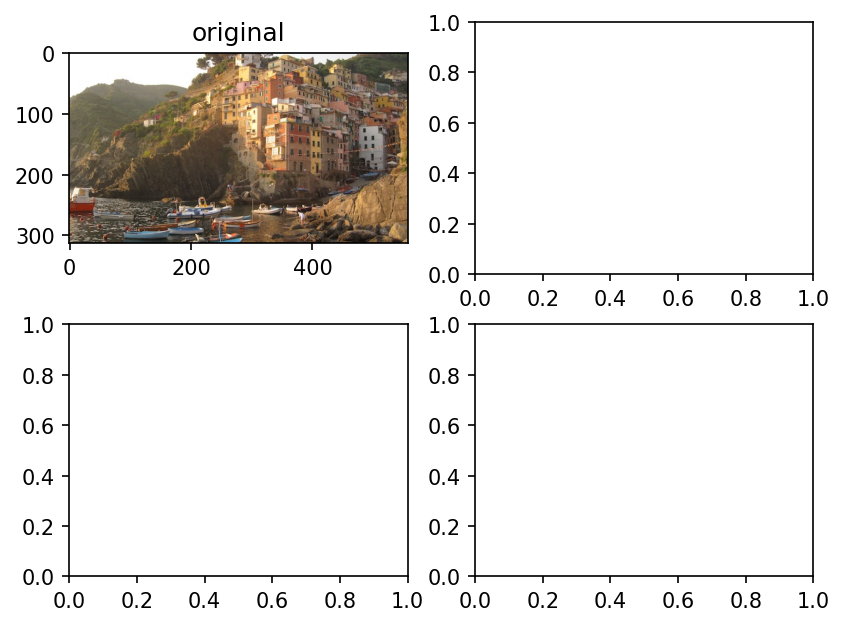

In [8]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,2, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW1/cinque_terre_small.jpg"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][1].imshow(plt.imread("HW1_output.png"))
ax[0][1].set_title("output")
ax[0][1].grid(False)

ax[1][0].imshow(plt.imread("HW1_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW1_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()